<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Светлана! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

<div class="alert alert-info">
<b>Комментарий студента:</b>
Привет, Марат! Спасибо за ревью. Свои комментарии я буду помечать так)
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Привет Светлана! Принято




</div>


# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Целью данного исследования** является выбор оптимальной модели для предсказания подходящего тарифа.

**Ход работы** включает в себя рассмотрение нескольких классификаторов, подбор оптимальных гиперпараметров и проверку самой "удачной" модели на тестовом наборе.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела.





</div>

## Откройте и изучите файл

In [1]:
# необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Собираем все импорты в верхней части, чтобы легче было ориентироваться и добавлять новые по необходимости. 


<div class="alert alert-warning">

Совет:     
    
    


- кстати есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html), в будущем пригодится )  



<div>

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Данные уже предобработаны и не содержат пропусков. 

Поскольку предстоит решать задачу классификации, следует также посмотреть на существующий баланс классов:

In [4]:
data['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

В представленных данных наблюдается выраженный дисбаланс классов: примерно 70% класс 0 (*тариф Смарт*) и 30% класс 1 (*тариф Ультра*).

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Есть проверка на сбалансированность




</div>


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

👍 Данные изучены.

  
    

<div class="alert alert-warning">



Совет: 


Можно еще отдельно проверить датасет на сбалансированность классов в таргете. Это важная информация при моделировании и помогло бы решить бонусное задание сразу.  Тема дисбаланса как раз тема следующего проекта, тут можно [почитать](https://dyakonov.org/2021/05/27/imbalance/) заранее зачем мы обращаем внимание на это. А [тут](https://habr.com/ru/post/349078/) так ли он страшен  ))




</div>


## Разбейте данные на выборки

Поскольку требуется построить модель для предсказания подходящего тарифа, значения *целевой переменной* записаны в столбце `is_ultra`: 1 - *тариф "Ультра"*, 0 - *тариф "Смарт".*

In [5]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

Разобьем датасет на три части: обучающую, валидационную и тестовую в соотношении 3:1:1. 

In [6]:
# выделим из данных тестовую выборку
features_full_train, features_test, target_full_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

# разделим оставшиеся на обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(
    features_full_train, target_full_train, test_size=0.25, random_state=12345, stratify=target_full_train)

In [7]:
features_train.shape[0], features_valid.shape[0], features_test.shape[0]

(1928, 643, 643)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все правильно!

Здорово что проконтролировано разбиение (можно с помощью .shape,  можно .len)

<div class="alert alert-warning">



Совет: 


- Обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут


</div>





<div class="alert alert-info">
<b>Комментарий студента:</b>
Исправила, и как все поменялось.. )
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Обычно после стратификации метрика чуть улучшается, но это не всегда так




</div>


## Исследуйте модели

Рассмотрим несколько известных моделей классификации: *дерево решений*, *случайный лес* и *логистическую регрессию*. Метрика для сравнения моделей - **accuracy** (доля правильных ответов).

### Дерево решений
Дерево решений характеризуется следующими гиперпараметрами:
- `max_depth` - максимальная глубина дерева
- `criterion` - критерий разделения (варианты:*gini*, *entropy*)
- `min_samples_split` - минимальное число объектов в узле, достаточное для разделения (по умолчанию: 2)
- `min_samples_leaf` - минимальное число объектов в листьях (по умолчанию: 1)

Будем варьировать первые 2 гиперпараметра, чтобы найти более оптимальный вариант реализации алгоритма.

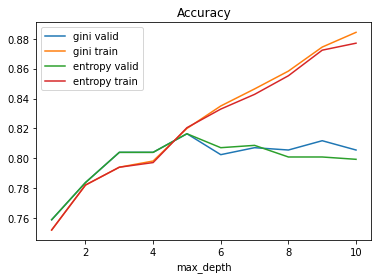

In [8]:
best_tree_model = None
best_criterion = None
best_max_depth = 0
best_result = 0

for sep_criterion in ['gini', 'entropy']:
    
    accuracy_valid_list, accuracy_train_list = [], []
    
    for depth in range(1, 11):
        model = DecisionTreeClassifier(max_depth=depth, criterion=sep_criterion, random_state=12345)
        model = model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        predictions_train = model.predict(features_train)
        
        accuracy_valid = accuracy_score(target_valid, predictions_valid)
        accuracy_train = accuracy_score(target_train, predictions_train)
        
        if accuracy_valid > best_result:
            best_tree_model = model
            best_criterion = sep_criterion
            best_max_depth = depth
            best_result = accuracy_valid
    
        accuracy_valid_list.append(accuracy_valid)
        accuracy_train_list.append(accuracy_train)
    
    plt.plot(range(1, 11), accuracy_valid_list, label=f'{sep_criterion} valid')
    plt.plot(range(1, 11), accuracy_train_list, label=f'{sep_criterion} train')

plt.legend()
plt.title('Accuracy')
plt.xlabel('max_depth')
plt.show()

In [9]:
print('Наибольшее значение accuracy =', round(best_result, 3))
print(f'Гиперпараметры дерева решений: criterion = {best_criterion}, max_depth = {best_max_depth}')

Наибольшее значение accuracy = 0.816
Гиперпараметры дерева решений: criterion = gini, max_depth = 5


In [10]:
# для хранения результатов оптимальных моделей
models_dict = {}
models_dict['DecisionTree'] = best_result

Как можно видеть по графику, оптимальным решением будет являться выбор максимальной глубины дерева, равной 5. При увеличении гиперпараметра наблюдается переобучение, при уменьшении - недообучение. При этом, выбор критерия разделения на изменение значения метрики влиять не будет (максимум достигается в одной и той же точке).

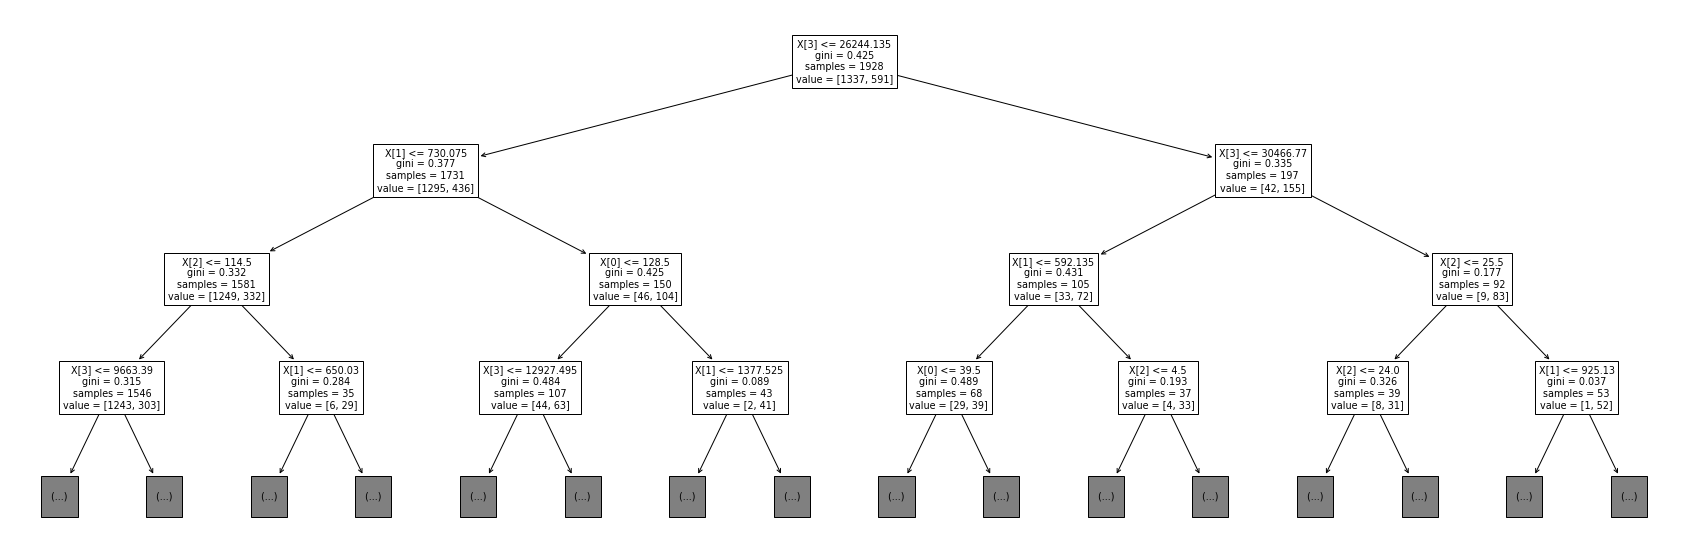

In [11]:
# принятие решений в созданном дереве
plt.figure(figsize=(30, 10))
plot_tree(best_tree_model, max_depth=3)
plt.show()

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
 
Работа выполнена в соответствии с критериями: 



 - модель обучена на обучающем наборе
 - получена оценка качества на валидационном наборе
 - перебор гиперпараметров осуществляется в цикле



<div class="alert alert-warning">


Совет: 

   


- Светлана, а почему бы в цикле сразу не записать лучшую модель, как ты это делаешь с лучшими гиперпараметрами? Тогда бы не пришлось обучать модель с лучшими гиперпараметрами опять. 



- Можно добавить график, хорошо оформленный график украсит проект. Тут на графике можно посмотреть как при изменении гиперпараметров меняется точность на train и validation датасете (для этого собираем наши метрики на валидации и train в списки, а затем по ним обычный plt.plot()) Такой способ используют чтобы лучше отследить переобучение



- tree_plot можно построить, с max_depth равной 3 или 4 (глубже уже будет громоздко) - глянуть как DT сплиты делает, будет понимание как модель принимает решения: какие признаки  использует, на каких значениях делает разбиение вправо - влево 




- criterion  это конечно гиперпараметр, но по большому счету это всего лишь разные способы расчета критерия информативности, при этом результат будет одинаковый (в 98% случаях). Вот [тут](https://www.quora.com/Why-is-entropy-used-instead-of-the-Gini-index) можно посмотреть на графики энтропии и джини, видно что они достигают максимума при одном и том же сплите 


</div>



<div class="alert alert-info">
<b>Комментарий студента:</b>
Построила сводный график. Линии для разных критериев действительно отличаются незначительно и максимумы совпадают. Для иллюстрации также привела дерево решений.
</div>




<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Совет:

1. tree_plot
    

    
Так красивей (схема)
    
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(35,20))
    _ = tree.plot_tree(your_model, 
                   feature_names=features.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 15)
    
    
2. График метрики  
    
    
Здорово!   
  
- Но нам же график не только для красоты, но и для анализа, с последующими действиями. Что мы видим тут? Как метрика на валидации еще не стала однозначна падать, это значит можно попробовать взять глубину побольше.  Вот когда на графике мы увидим как метрика достигнув пика начинает однозначно падать, вот тут мы и сможем сделать вывод что модель переобучается после такого то значения max_depth и дальше перебирать уже не имеет смысла - модель запоминает данные, а не обобщает. 

    
- Здорово что отметила про критерии. Доверяй но проверяй )
</div>




### Случайный лес
Поскольку *случайный лес* представляет собой ансамбль нескольких решающих деревьев, к набору гиперпараметров добавляется `n_estimators` - количество деревьев в лесу.

Будем варьировать те же гиперпараметры, что и в предудыщем случае + новый добавленный. 

In [12]:
%%time

best_forest_model = None
best_criterion = None
best_max_depth = 0
best_est = 0
best_result = 0

for sep_criterion in ['gini', 'entropy']:
    for est in range(1, 51, 5):
        for depth in range(1, 11):
            model = RandomForestClassifier(n_estimators=est, max_depth=depth, criterion=sep_criterion, random_state=12345)
            model = model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            accuracy = accuracy_score(target_valid, predictions)
        
            if accuracy > best_result:
                best_forest_model = model
                best_criterion = sep_criterion
                best_max_depth = depth
                best_est = est
                best_result = accuracy

CPU times: user 13.6 s, sys: 169 ms, total: 13.8 s
Wall time: 13.8 s


In [13]:
print('Наибольшее значение accuracy =', round(best_result, 3))
print(f'Гиперпараметры случайного леса: criterion = {best_criterion}, max_depth = {best_max_depth}, n_estimators = {best_est}')

Наибольшее значение accuracy = 0.829
Гиперпараметры случайного леса: criterion = gini, max_depth = 8, n_estimators = 16


In [14]:
models_dict['RandomForest'] = best_result




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
    
По большему числу гиперпараметров перебор -   тем лучше метрика. Здорово   




<div class="alert alert-warning">


Совет: 

- Здорово что использован перебор не по одному гиперпараметру. Поэтому посоветую поизучать sklearn-ий GreedSearchCV. В случаи использования GridSearch, не нужно будет заранее делать валидационную выборку, лучшую метрику автоматом сохранят в best_score_, а лучшую модель (переобученная уже на полном наборе данных) будет хранить в best_estimator_. Это тема будущих теоретических занятий, но если есть время можешь сразу попробовать.




- Когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить ))  А еще есть tqdm, показывает на каком этапе у нас работа в цикле происходит


</div>


<div class="alert alert-info">
<b>Комментарий студента:</b>
Решение 2 для Random Forest (с использованием GridSearchCV). Варьировала те же самые параметры, что и ранее (чтоб сравнить). В итоге получились немного другие значения параметров и accuracy ниже, чем был. К тому же время работы значительно увеличилось. Разве не должны модели в этом случае совпадать? И значение метрики тоже? Может, в данном случае, gridsearch использует какое-то другое разделение на обучение и проверку внутри? 
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех:

Здорово что использован GridSearchCV, это уже другой уровень  и подала верный датасет    
    
    


<div class="alert alert-warning">

Совет:


- Насчёт долго - первое он делает разбивку 5 раз, и каждый раз все пересчитывает (cv=5), во вторых он после того как найдет лучшие гиперпараметры, дообучает модель на полном датасете, еще и данные собирает о обучении. Так что если он долго считает то не потому что плохо оптимизирован, с этим у него все в порядке, а потому что он делает очень много полезной работы. 
    

    
- не забываем при инициализации модели random_state
    
    
    




- Благодаря кроссвалидации (cv = 5), модель полученная с помощью GridSearchCV будет стабильней (меньше рандома, потому что обучение - валидация шла на разных обьектах) и на тесте обычно показывает лучший результат. Но Из-за cross-validation результаты простой итерации и GS почти всегда будут отличаться.  Но механизм одинаковый, один в один.  


    
- В случаи с GS тоже можно отлично строить графики, глянь в атрибут .cv_results_, там собрана информация о процессе обучения, можно оттуда вытащить данные, чтобы построить график.
    
    
 

</div>

 

In [15]:
%%time

model = RandomForestClassifier()

parameters = { 'n_estimators': range (1, 51, 5),
              'max_depth': range (1,11),
              'criterion': ['gini', 'entropy']}

grid = GridSearchCV(model, parameters, scoring='accuracy')
grid.fit(features_full_train, target_full_train)

CPU times: user 1min 11s, sys: 842 ms, total: 1min 12s
Wall time: 1min 12s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11),
                         'n_estimators': range(1, 51, 5)},
             scoring='accuracy')

In [16]:
# models_dict['RandomForest_new'] = grid.best_score_
print('New accuracy:', round(grid.best_score_, 3))
print('Оптимальные параметры:', grid.best_params_)

New accuracy: 0.809
Оптимальные параметры: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 26}


### Логистическая регрессия
Гиперпараметров, способных критически повлиять на результат, у *логистической регрессии* нет, поэтому обучим модель с параметрами по умолчанию и посмотрим на значение метрики.

In [17]:
model = LogisticRegression(random_state=12345)
new_model = model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)

In [18]:
print('Accuracy логистической регрессии =', round(accuracy, 3))

Accuracy логистической регрессии = 0.756


In [19]:
models_dict['LogisticRegression'] = accuracy

### Вывод:

Таким образом, лучший результат показала модель, обученная алгоритмом *Случайный лес* со следующими значениями гиперпараметров:
- **критерий разделения**: Джинни
- **максимальная глубина дерева**: 8
- **количество деревьев в ансамбле**: 16 

Доля правильных ответов на валидационной выборке: **0.829**.

In [20]:
# инициирование итоговой модели
best_model = best_forest_model



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Все верно, RF лучший. 


<div class="alert alert-warning">


Совет: 

Если есть желание можешь ответить на вопросики ))    



- Как назвать ситуацию, когда на валидации при увеличении глубины дерева (модель DT), метрика качества стала снижаться? Как по твоему в это же время вела себя эта же метрика на train?


- Насколько знаю вы еще под капот моделям не заглядывали, но может знаешь почему обычно RF показывает более высокие результаты из выбранных?


- Мы решаем задачу классификации (а еще есть задача регрессии), а в названии модели с помощью которой мы решаем задачу "классификации" есть слово "регрессия".  Нет ли тут парадокса? )
    

- Почему логистическая регрессия показывать на много более худшие результаты?  


</div>





<div class="alert alert-info">
<b>Комментарий студента:</b>
1. Это и называется переобучением. Т.е. модель начала лучше описывать обучающий набор (на train метрика будет расти), но хуже - ранее ей неизвестные данные.
    
2. Потому что там используется целый ансамбль деревьев решений, каждое из которых обучается независимо и дает определенный ответ. Ответы всех деревьев агрегируются и разделение получается более точным.
    
3. В логистической регрессии схожий принцип работы с линейной регрессией, однако, тут алгоритмом вычисляется не значение, а вероятность, что объект принадлежит к одному или другому классу.
    
4. Предположу, что это из-за того, что логистическая регрессия пытается провести линейную границу между двумя классами, однако, зачастую реальная граница от линейной далека.
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>


Успех:


Дополню чуть

1. Верно, переобучение. На train точность растет вплоть до 100%. Это можно было увидеть на твоём графике, если бы ты взяла перебор поглубже
    
    
2. Да, в RF обучается несколько деревьев, а решение принимается путем голосования. Каждое дерево в RF учится на своем датасете (используется техника бутстрап), таким образом достигается "независимость" этих самых деревьев, в итоге ошибка разброса снижается.

    
3. "Регрессия", потому что внутри нее скалярное произведение (как и в линейной регрессии), дающее на выходе вещественное число (от + бесконечности до - бесконечности), на это число вешают сигмойду, логарифм и получают значение от 0 до 1 (вероятность класса).   
    
    
4. Верно. Логистическая регрессия плоха (и хороша с другой стороны) тем что это линейный классификатор: обьекты на классы разделяем гиперплоскостью (прямой если на плоскости), а в данном датасете видимо более сложные, нелинейные связи между признаками и таргетом.   А RF с DT с этим справляются. На других данных  LR могла оказаться лучше, например потому что RF не может экстраполировать. 


</div>

## Проверьте модель на тестовой выборке

In [21]:
predictions_test = best_model.predict(features_test)
print('Accuracy на тестовой выборке:', round(accuracy_score(target_test, predictions_test), 3))

Accuracy на тестовой выборке: 0.812


В 4 из 5 случаях выбранная модель дает правильный ответ. Попробуем увеличить метрику качества, заново обучив модель с выбранными значениями гиперпараметров, но на "общей" выборке: train+valid.

In [27]:
full_model = RandomForestClassifier(n_estimators=16, max_depth=8, criterion='gini', random_state=12345)
full_model = full_model.fit(features_full_train, target_full_train)
predictions_valid = full_model.predict(features_valid)
predictions_test = full_model.predict(features_test)

print('Accuracy на валидационной выборке:', round(accuracy_score(target_valid, predictions_valid), 3))
print('Accuracy на тестовой выборке:', round(accuracy_score(target_test, predictions_test), 3))

Accuracy на валидационной выборке: 0.868
Accuracy на тестовой выборке: 0.82


Для сравнения используем модель случайного леса с параметрами, оптимизированными с помощью GridSearchCV:

In [23]:
predictions_test = grid.best_estimator_.predict(features_test)
print('Accuracy на тестовой выборке:', round(accuracy_score(target_test, predictions_test), 3))

Accuracy на тестовой выборке: 0.809


Результат немного хуже.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Ну бывает )




</div>




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель (или парочку, если метрики были близки) отобранную на валидации. 

- Если студент получил на тесте accuraсy  выше 0,78, это считается отличным результатом. Ты подбираешь лучшую комбинацию не по одному гиперпараметру и вот он результат!



<div class="alert alert-warning">

Вопросики и совет:




- Как попробовать улучшить результат, не мучаясь с кодом?! Смотри - мы сформировали train выборку на которой обучаем модель, а валидационную используем для поиска лучших значений гиперпараметров. Оке, нашли их. Так почему бы теперь модель с выбранными гиперпараметрами не обучить на тренировочной + валидационной выборке (только не нужно делать новые сплиты, используй pd.concat(), к примеру)?! Чем больше данных, тем лучше модель может обучиться. И эту дообученную модель проверим на тесте. Гаранитий что станет лучше нет, но ML это постоянные эксперименты.  
    
   
<div>

## (бонус) Проверьте модели на адекватность

In [24]:
target.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Представленные данные характеризуются дисбалансом классов: примерно 70% - класс 0 (*Смарт*) и 30% - класс 1 (*Ультра*). Распределение аналогично и для обучающей выборки.

Тогда доля правильных ответов для **константной модели** (модели, которая в любом случае определяет объект к одному классу, например, к 0):

In [25]:
target_valid.value_counts(normalize=True).head(1)

0    0.693624
Name: is_ultra, dtype: float64

In [26]:
# другие модели
for key, value in models_dict.items():
    print('Accuracy для оптимальной модели', key, 'равно', round(value, 3))

Accuracy для оптимальной модели DecisionTree равно 0.816
Accuracy для оптимальной модели RandomForest равно 0.829
Accuracy для оптимальной модели LogisticRegression равно 0.756


Значение для константной модели ниже, чем получаемые значения accuracy для рассмотренных моделей. Следовательно, построенные модели предсказывают правильные ответы лучше и их можно считать **адекватными**.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все верно. 



<div class="alert alert-warning">

Совет: 

При проверке на адекватность модели, рекомендую ознакомиться с [Dummy Models](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html), это удобная обертка для константных моделей

</div>



## Общий вывод

**Основной задачей проекта** было решение задачи *бинарной классификации*: научиться предсказывать пользователям подходящий тариф (*Смарт или Ультра*) на основе данных о поведении клиентов, уже сделавших выбор. Данные были предоставлены в предобработанном виде.

В рамках исследования было проведено сравнение нескольких алгоритмов классификации - *Дерево решений*, *Случайный лес* и *Логистическая регрессия*. Для моделей, обученных по первым двум алгоритмам, были подобраны оптимальные гиперпараметры, которые позволили максимизировать *долю правильных ответов (accuracy)* - метрику, выбранную для оценки. Построенные модели также были дополнительно проверены на адекватность сравнением с простой константной моделью, предсказывающей в 100% случаев класс 0.

**Наилучший результат** показала модель, обученная алгоритмом *Случайный лес*, содержащим в себе 16 независимых решающих деревьев, с максимальной глубиной дерева = 8 и установленным критерием разделения Джинни. 

Доля правильных ответов: **0.829** на валидационной выборке и **0.812** на тестовой (**0.82** если обучить модель на совокупности обучающей и валидационной выборок).

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Светлана, здорово что в конце расписаны все этапы работы. Это важно потому что когда проект захочет посмотреть будущий работодатель (или начальник), у него может не быть времени на подробный разбор кода. Вероятнее всего он бегло просмотрит код, а из общего вывода захочет получить представление о всей работе.



</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>




Светлана, у тебя старательно выполненная работа, все четко, осмысленно. Выводы присутствуют, с комментированием кода тоже никаких проблем нет, твоих объяснений достаточно для понимания коллегами хода твоих мыслей. 

    
    
    
Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить): 




- обрати внимание на проверку сбалансированность классов в таргете в разделе EDA
- использовать stratify
- добавить график метрики    
- посоветовал посмотреть в сторону GridSearchCV
- как можно улучшить результаты 



Посылаю на вторую итерацию, чтобы ответить на вопросы если они появятся


</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    
Красное исправлено, многие желтые советы использованы, на  вопросы есть ответы  (это все было по желанию), значит стремишься развиваться, а желание и интерес это главное. Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.



  
Отличная работа Светлана. Желаю успехов в дальнейшей учебе!




</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
